# 08 — Evaluation & Interpretation

**Goal:** Deep-dive into model performance and explain *why* predictions are made.

**Inputs:** `../models/advanced_models.pkl` · `../data/processed/X_train/test_{pos}.csv` · `y_train/test_{pos}.csv` · `featured_{pos}.csv` · `advanced_results.json` · `baseline_results.json`

**Outputs:** `../figures/08_*.png` · `../data/processed/shap_values_{pos}.npy` · `../data/processed/shap_base_values_{pos}.npy`

**Next:** `09_undervalued_players_and_dream_team.ipynb`

---
**Analyses:**
1. Overall metric recap — advanced vs baseline per position
2. Residual distribution — where errors concentrate
3. Error by market value range — do expensive players hurt performance?
4. Error by age group — are young/veteran players harder to predict?
5. SHAP global importance — which features actually drive predictions?
6. Best & worst predictions — who is most over/underestimated?

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import json
import os
import pickle
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.inspection import permutation_importance

try:
    import shap
    SHAP_AVAILABLE = True
    print('SHAP available ✓')
except ImportError:
    SHAP_AVAILABLE = False
    print('SHAP not found — install with: pip install shap')
    print('Error analysis sections will still run.')

PROC_PATH    = '../data/processed/'
SPLITS_PATH  = '../data/processed/splits/'
FEAT_PATH    = '../data/processed/featured/'
MODELS_PATH  = '../models/'
FIGURES_PATH = '../figures/'
os.makedirs(FIGURES_PATH, exist_ok=True)

POSITIONS    = ['GK', 'DEF', 'MID', 'ATT']
RANDOM_STATE = 42

## 1. Load Models, Splits & Results

In [ ]:
with open(MODELS_PATH + 'advanced_models.pkl', 'rb') as f:
    models = pickle.load(f)

with open(PROC_PATH + 'final_features.json') as f:
    FINAL_FEATURES = json.load(f)

with open(PROC_PATH + 'baseline_results.json') as f:
    baseline_results = json.load(f)

with open(PROC_PATH + 'advanced_results.json') as f:
    advanced_results = json.load(f)

# Preprocessed splits (scaled features) — index is 0-based row position
splits = {}
for pos in POSITIONS:
    p = pos.lower()
    X_train = pd.read_csv(SPLITS_PATH + f'X_train_{p}.csv', index_col=0)
    X_test  = pd.read_csv(SPLITS_PATH + f'X_test_{p}.csv',  index_col=0)
    y_train = pd.read_csv(SPLITS_PATH + f'y_train_{p}.csv', index_col=0).squeeze()
    y_test  = pd.read_csv(SPLITS_PATH + f'y_test_{p}.csv',  index_col=0).squeeze()
    splits[pos] = (X_train, X_test, y_train, y_test)

# Featured data — load WITHOUT index_col so index matches y_test.index (row positions)
featured = {}
for pos in POSITIONS:
    featured[pos] = pd.read_csv(FEAT_PATH + f'featured_{pos.lower()}.csv')

print('Loaded:')
for pos in POSITIONS:
    name = advanced_results[pos]['best']['name']
    r2   = advanced_results[pos]['best']['test']['R2']
    _, X_test, _, y_test = splits[pos]
    print(f'  {pos}: {name}  test R²={r2:.3f}  '
          f'index sample={list(y_test.index[:3])}')

## 2. Metric Recap — Advanced vs Baseline

In [4]:
rows = []
for pos in POSITIONS:
    base_r2   = max(baseline_results[pos][m]['test']['R2'] for m in baseline_results[pos])
    base_rmse = min(baseline_results[pos][m]['test']['RMSE_EUR_M'] for m in baseline_results[pos])
    adv       = advanced_results[pos]['best']
    rows.append({
        'Position':       pos,
        'Model':          adv['name'],
        'Baseline R²':    base_r2,
        'Advanced R²':    adv['test']['R2'],
        'R² gain':        round(adv['test']['R2'] - base_r2, 4),
        'Baseline RMSE':  base_rmse,
        'Advanced RMSE':  adv['test']['RMSE_EUR_M'],
        'RMSE gain (€M)': round(base_rmse - adv['test']['RMSE_EUR_M'], 3),
    })

recap_df = pd.DataFrame(rows)
print(recap_df.to_string(index=False))

Position   Model  Baseline R²  Advanced R²  R² gain  Baseline RMSE  Advanced RMSE  RMSE gain (€M)
      GK XGBoost       0.7124       0.7878   0.0754          2.339          1.952           0.387
     DEF XGBoost       0.7640       0.8265   0.0625          3.300          1.953           1.347
     MID XGBoost       0.7706       0.8294   0.0588          6.149          4.097           2.052
     ATT XGBoost       0.7504       0.8089   0.0585          3.697          2.951           0.746


## 3. Residual Distribution

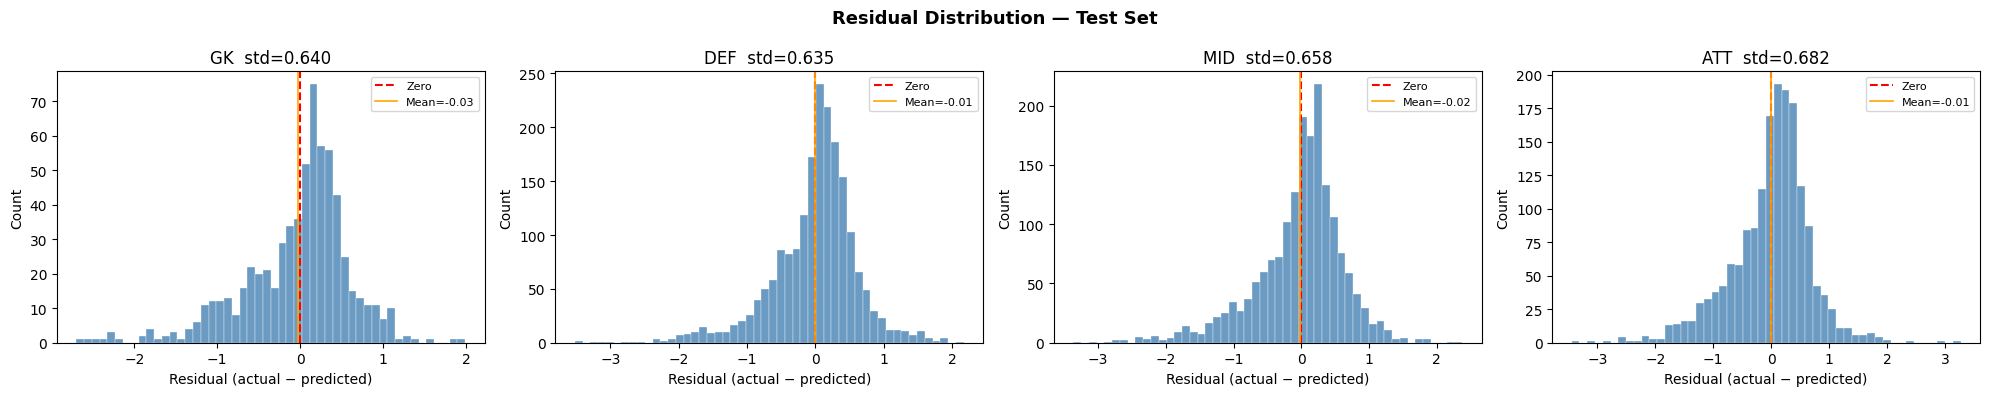

Saved.


In [5]:
fig, axes = plt.subplots(1, 4, figsize=(20, 4), sharey=False)

for ax, pos in zip(axes, POSITIONS):
    X_train, X_test, y_train, y_test = splits[pos]
    y_pred    = models[pos].predict(X_test)
    residuals = y_test.values - y_pred

    ax.hist(residuals, bins=50, color='steelblue', alpha=0.8, edgecolor='white', linewidth=0.3)
    ax.axvline(0,            color='red',    linewidth=1.5, linestyle='--', label='Zero')
    ax.axvline(residuals.mean(), color='orange', linewidth=1.2, linestyle='-',  label=f'Mean={residuals.mean():.2f}')
    ax.set_xlabel('Residual (actual − predicted)')
    ax.set_ylabel('Count')
    ax.set_title(f'{pos}  std={residuals.std():.3f}')
    ax.legend(fontsize=8)

plt.suptitle('Residual Distribution — Test Set', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig(FIGURES_PATH + '08_residual_distribution.png')
plt.show()
print('Saved.')

## 4. Error by Market Value Range

Split test set into 5 equal-sized bins by actual market value (€).
Higher-value bins are smaller in count but potentially higher in RMSE.

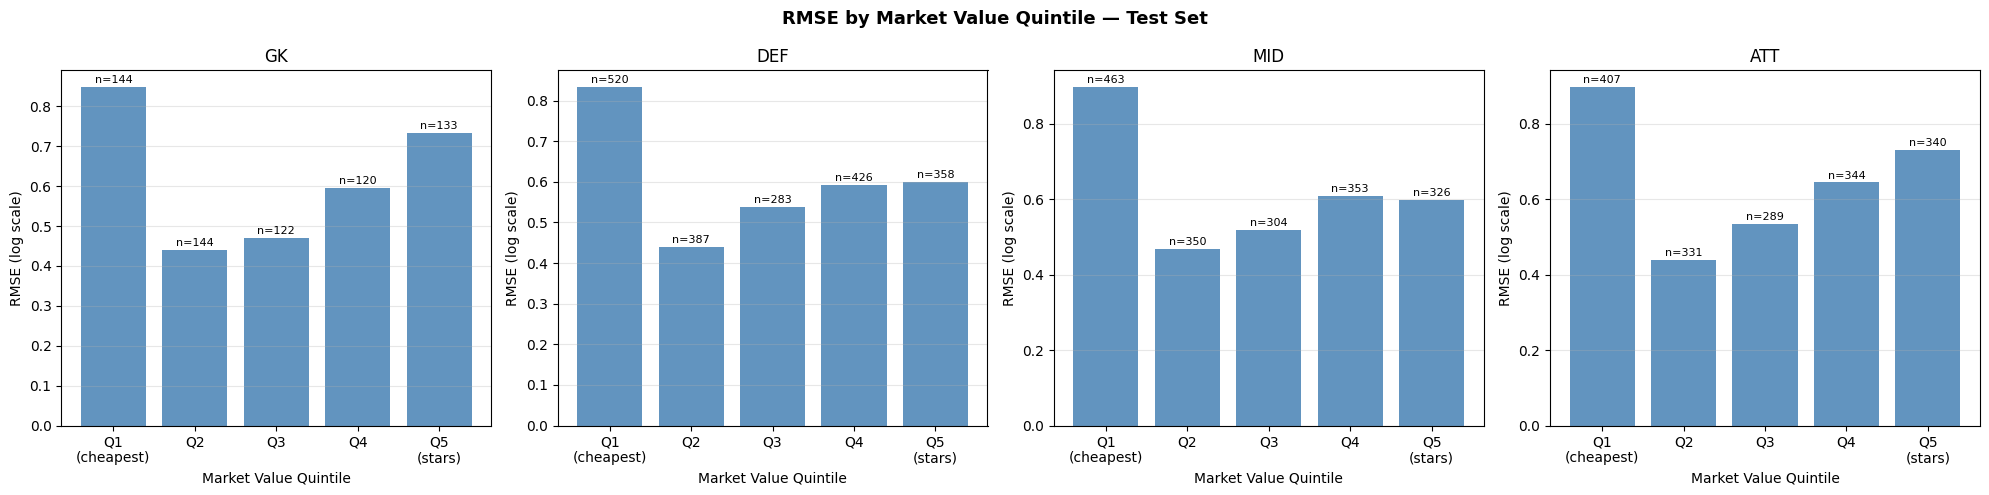

Saved.


In [6]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for ax, pos in zip(axes, POSITIONS):
    X_train, X_test, y_train, y_test = splits[pos]
    y_pred = models[pos].predict(X_test)

    # Join actual EUR value from featured data by player_id index
    feat   = featured[pos]
    eur_vals = feat.loc[y_test.index, 'market_value_in_eur']

    df_err = pd.DataFrame({
        'actual_log':  y_test.values,
        'pred_log':    y_pred,
        'market_eur':  eur_vals.values,
    })
    df_err['bin'] = pd.qcut(df_err['market_eur'], q=5,
                            labels=['Q1\n(cheapest)', 'Q2', 'Q3', 'Q4', 'Q5\n(stars)'])

    rmse_by_bin = df_err.groupby('bin', observed=True).apply(
        lambda g: np.sqrt(mean_squared_error(g['actual_log'], g['pred_log']))
    )
    count_by_bin = df_err.groupby('bin', observed=True).size()

    bars = ax.bar(rmse_by_bin.index, rmse_by_bin.values, color='steelblue', alpha=0.85)
    for bar, cnt in zip(bars, count_by_bin.values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                f'n={cnt}', ha='center', va='bottom', fontsize=8)

    ax.set_title(f'{pos}')
    ax.set_xlabel('Market Value Quintile')
    ax.set_ylabel('RMSE (log scale)')
    ax.grid(axis='y', alpha=0.3)

plt.suptitle('RMSE by Market Value Quintile — Test Set', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig(FIGURES_PATH + '08_error_by_value_range.png')
plt.show()
print('Saved.')

## 5. Error by Age Group

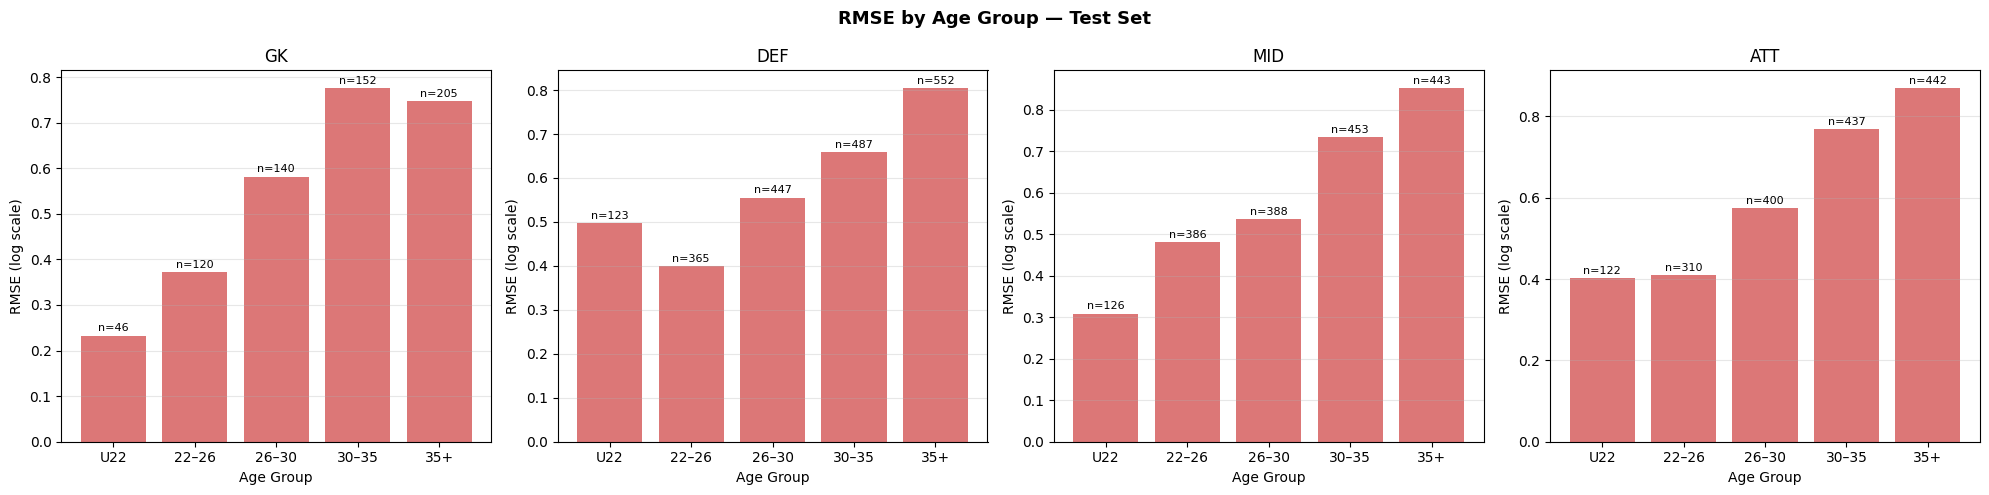

Saved.


In [7]:
AGE_BINS   = [15, 22, 26, 30, 35, 46]
AGE_LABELS = ['U22', '22–26', '26–30', '30–35', '35+']

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for ax, pos in zip(axes, POSITIONS):
    X_train, X_test, y_train, y_test = splits[pos]
    y_pred = models[pos].predict(X_test)

    feat = featured[pos]
    ages = feat.loc[y_test.index, 'age']

    df_age = pd.DataFrame({
        'actual_log': y_test.values,
        'pred_log':   y_pred,
        'age':        ages.values,
    })
    df_age['age_group'] = pd.cut(df_age['age'], bins=AGE_BINS, labels=AGE_LABELS, right=False)

    rmse_by_age  = df_age.groupby('age_group', observed=True).apply(
        lambda g: np.sqrt(mean_squared_error(g['actual_log'], g['pred_log'])) if len(g) > 1 else np.nan
    ).dropna()
    count_by_age = df_age.groupby('age_group', observed=True).size()

    bars = ax.bar(rmse_by_age.index, rmse_by_age.values, color='#D65F5F', alpha=0.85)
    for bar, grp in zip(bars, rmse_by_age.index):
        cnt = count_by_age.get(grp, 0)
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                f'n={cnt}', ha='center', va='bottom', fontsize=8)

    ax.set_title(f'{pos}')
    ax.set_xlabel('Age Group')
    ax.set_ylabel('RMSE (log scale)')
    ax.grid(axis='y', alpha=0.3)

plt.suptitle('RMSE by Age Group — Test Set', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig(FIGURES_PATH + '08_error_by_age.png')
plt.show()
print('Saved.')

## 6. SHAP — Global Feature Importance

SHAP (SHapley Additive exPlanations) assigns each feature a contribution to each individual prediction.
- `TreeExplainer` for XGBoost/RF — exact, fast
- `KernelExplainer` for MLP — approximate, uses a small background sample

Computed on the **test set** to reflect real-world behaviour.

In [8]:
shap_values_dict    = {}
shap_expected_dict  = {}

if SHAP_AVAILABLE:
    for pos in POSITIONS:
        X_train, X_test, y_train, y_test = splits[pos]
        model = models[pos]

        if hasattr(model, 'feature_importances_'):   # XGBoost or RF
            explainer  = shap.TreeExplainer(model)
            sv         = explainer.shap_values(X_test)
            expected   = explainer.expected_value
        else:                                         # MLP — use Kernel with small background
            bg = shap.sample(X_train, 100, random_state=RANDOM_STATE)
            explainer  = shap.KernelExplainer(model.predict, bg)
            sv         = explainer.shap_values(X_test.iloc[:200])  # subset for speed
            expected   = explainer.expected_value

        shap_values_dict[pos]   = sv
        shap_expected_dict[pos] = expected
        print(f'  {pos}: SHAP computed  shape={np.array(sv).shape}')
else:
    print('SHAP not available — skipping SHAP sections.')

  GK: SHAP computed  shape=(663, 18)
  DEF: SHAP computed  shape=(1974, 19)
  MID: SHAP computed  shape=(1796, 18)
  ATT: SHAP computed  shape=(1711, 19)


### 6a. SHAP Mean Absolute Value — Bar Chart

Average |SHAP value| per feature = mean contribution to prediction magnitude.
This is the most stable feature importance measure.

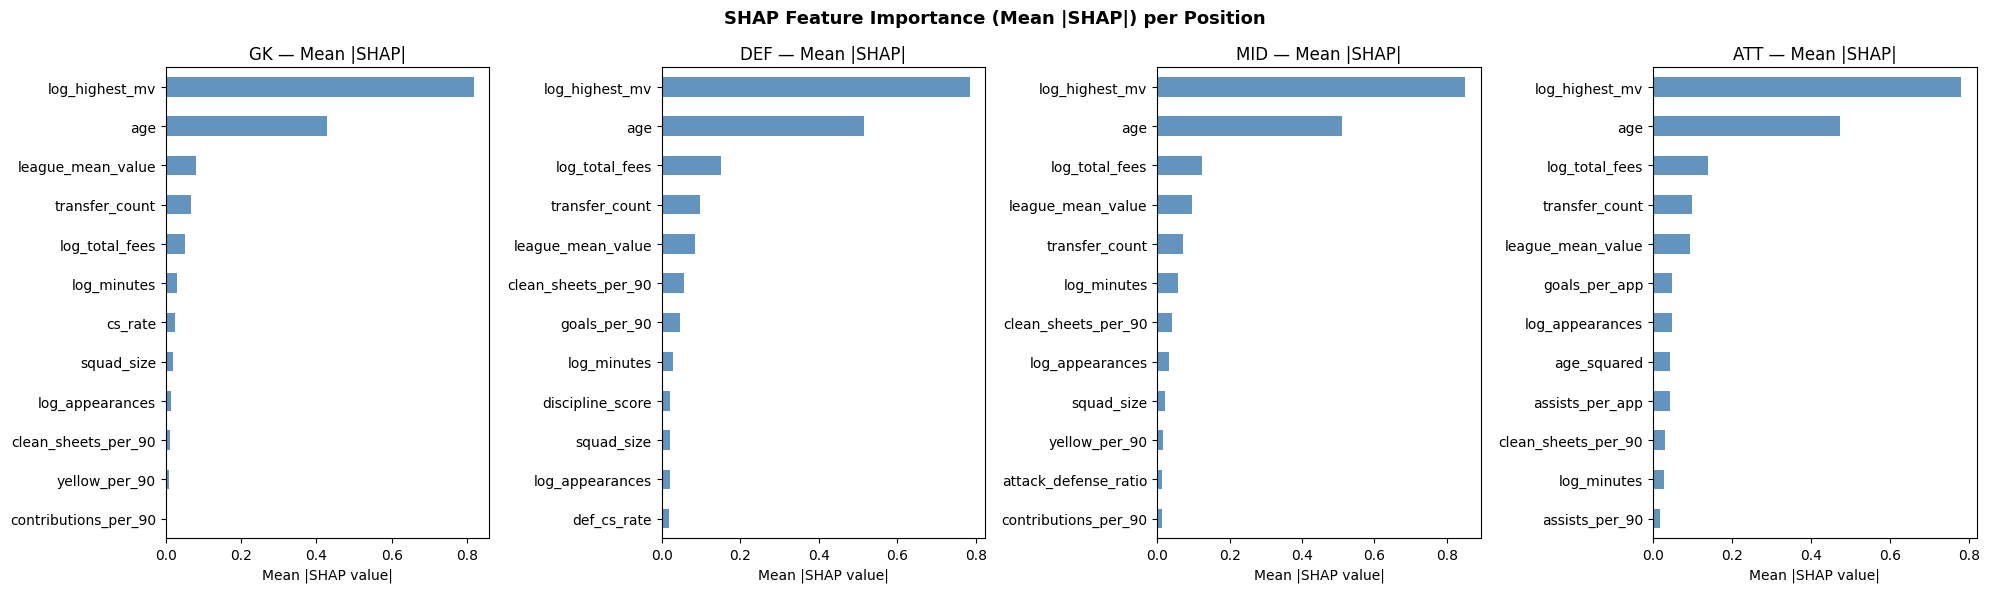

Saved.


In [9]:
if SHAP_AVAILABLE and shap_values_dict:
    fig, axes = plt.subplots(1, 4, figsize=(20, 6))

    for ax, pos in zip(axes, POSITIONS):
        sv    = np.array(shap_values_dict[pos])
        feats = FINAL_FEATURES[pos]
        mean_abs = pd.Series(np.abs(sv).mean(axis=0), index=feats).sort_values()

        mean_abs.tail(12).plot(kind='barh', ax=ax, color='steelblue', alpha=0.85)
        ax.set_title(f'{pos} — Mean |SHAP|')
        ax.set_xlabel('Mean |SHAP value|')

    plt.suptitle('SHAP Feature Importance (Mean |SHAP|) per Position', fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.savefig(FIGURES_PATH + '08_shap_bar.png')
    plt.show()
    print('Saved.')
else:
    print('Skipped — SHAP not available.')

### 6b. SHAP Beeswarm Plot

Shows both **magnitude** (x-axis) and **direction** (colour = feature value).
Each dot is one test player. Red = high feature value, Blue = low feature value.

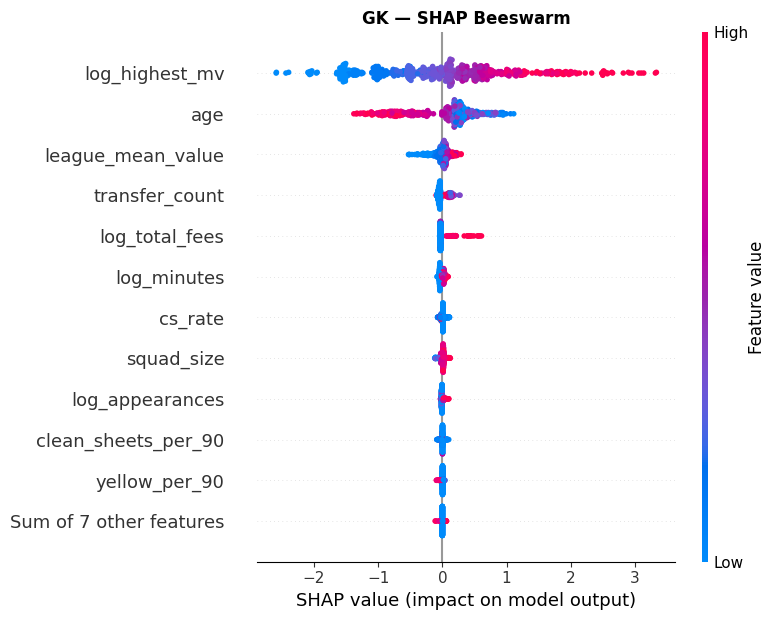

  GK: saved.


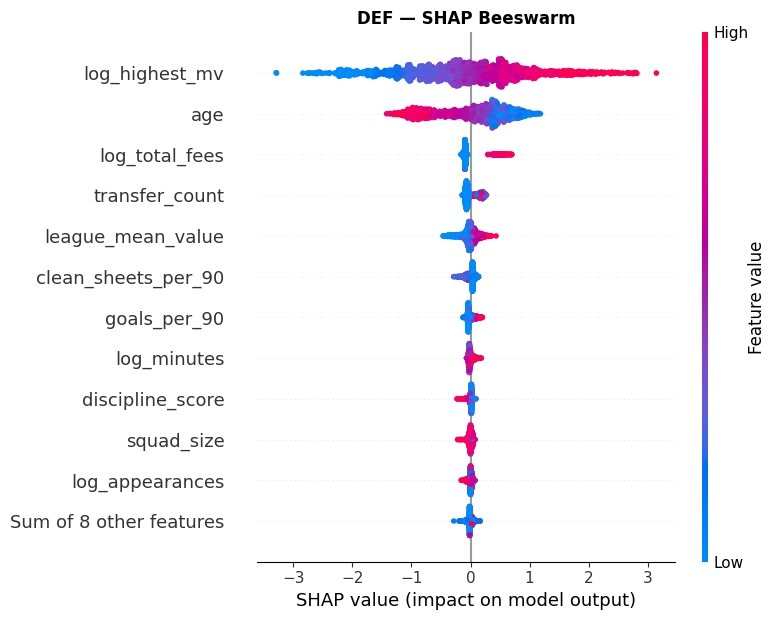

  DEF: saved.


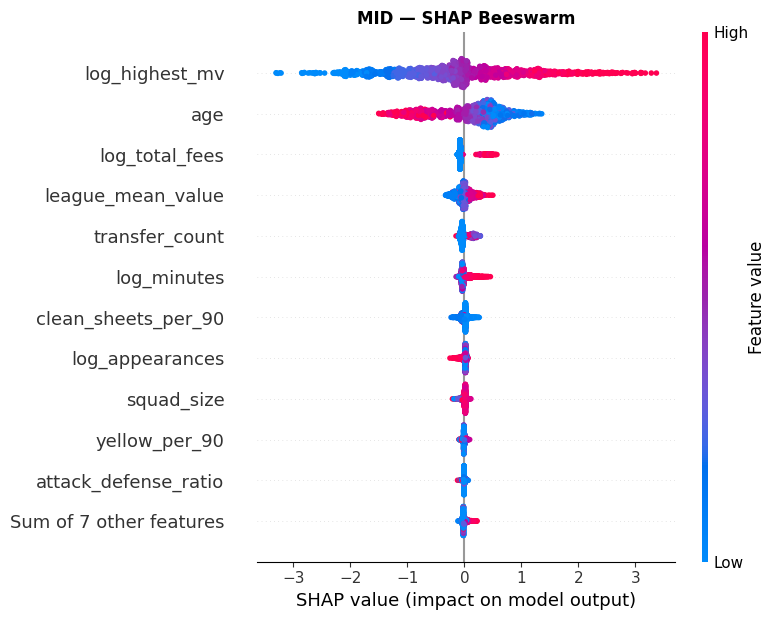

  MID: saved.


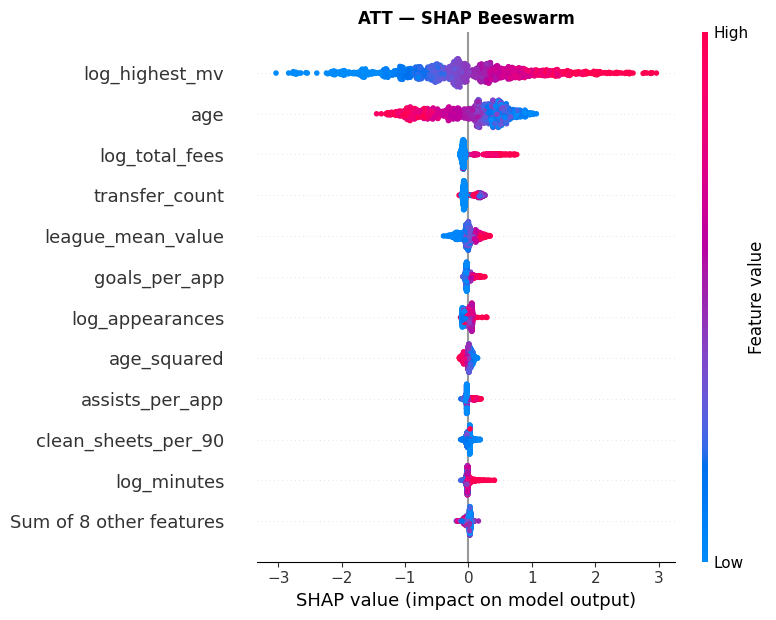

  ATT: saved.


In [10]:
if SHAP_AVAILABLE and shap_values_dict:
    for pos in POSITIONS:
        X_train, X_test, y_train, y_test = splits[pos]
        sv    = shap_values_dict[pos]
        feats = FINAL_FEATURES[pos]

        # Use Explanation object for new-API plots
        shap_exp = shap.Explanation(
            values         = sv,
            base_values    = np.full(len(sv), shap_expected_dict[pos]),
            data           = X_test.values if isinstance(sv, np.ndarray) and sv.shape[0] == len(X_test) else X_test.iloc[:200].values,
            feature_names  = feats
        )

        plt.figure(figsize=(9, 6))
        shap.plots.beeswarm(shap_exp, max_display=12, show=False)
        plt.title(f'{pos} — SHAP Beeswarm', fontsize=12, fontweight='bold')
        plt.tight_layout()
        plt.savefig(FIGURES_PATH + f'08_shap_beeswarm_{pos.lower()}.png')
        plt.show()
        print(f'  {pos}: saved.')
else:
    print('Skipped — SHAP not available.')

## 7. Best & Worst Predictions

Identify players the model strongly under- or over-estimates.
**Underestimated** (actual >> predicted) → hidden gems for notebook 09.
**Overestimated** (predicted >> actual) → overhyped / declining players.

In [11]:
TOP_N = 5

for pos in POSITIONS:
    X_train, X_test, y_train, y_test = splits[pos]
    y_pred = models[pos].predict(X_test)
    feat   = featured[pos]  # integer row-position index

    df_pred = pd.DataFrame({
        'actual_log': y_test.values,
        'pred_log':   y_pred,
        'residual':   y_test.values - y_pred,
    }, index=y_test.index)

    # Join by row index — feat has same 0-based index
    df_pred = df_pred.join(feat[['name', 'age', 'market_value_in_eur']])
    df_pred['pred_eur_M']   = np.expm1(df_pred['pred_log'])          / 1e6
    df_pred['actual_eur_M'] = df_pred['market_value_in_eur']         / 1e6

    cols = ['name', 'age', 'actual_eur_M', 'pred_eur_M', 'residual']
    print(f'\n{pos} — Top {TOP_N} UNDERESTIMATED (actual >> predicted):')
    print(df_pred.nlargest(TOP_N, 'residual')[cols].to_string(index=False))

    print(f'\n{pos} — Top {TOP_N} OVERESTIMATED (predicted >> actual):')
    print(df_pred.nsmallest(TOP_N, 'residual')[cols].to_string(index=False))
    print()


GK — Top 5 UNDERESTIMATED (actual >> predicted):
             name  age  actual_eur_M  pred_eur_M  residual
     Márton Fülöp   42          1.25    0.170895  1.989844
    Víctor Valdés   43          2.00    0.309501  1.865937
Miguel Ángel Moyá   41          0.80    0.159731  1.611117
  Guillermo Ochoa   40          1.00    0.243544  1.412454
Geoffrey Jourdren   39          1.00    0.265930  1.324519

GK — Top 5 OVERESTIMATED (predicted >> actual):
            name  age  actual_eur_M  pred_eur_M  residual
  Igor Levchenko   34         0.010    0.148642 -2.698864
Norbert Haymamba   26         0.010    0.131176 -2.573864
    Brian Murphy   42         0.010    0.114222 -2.435467
  Ivan Pelizzoli   45         0.025    0.266778 -2.367504
  Utku Yuvakuran   28         0.050    0.503226 -2.308999


DEF — Top 5 UNDERESTIMATED (actual >> predicted):
            name  age  actual_eur_M  pred_eur_M  residual
     Juan Valera   41           2.0    0.228332  2.170099
Vitaliy Mandzyuk   39          

## 8. SHAP Waterfall — Individual Predictions

Waterfall plot for the **most underestimated player per position** — shows exactly
which features pushed the prediction down vs the true value.

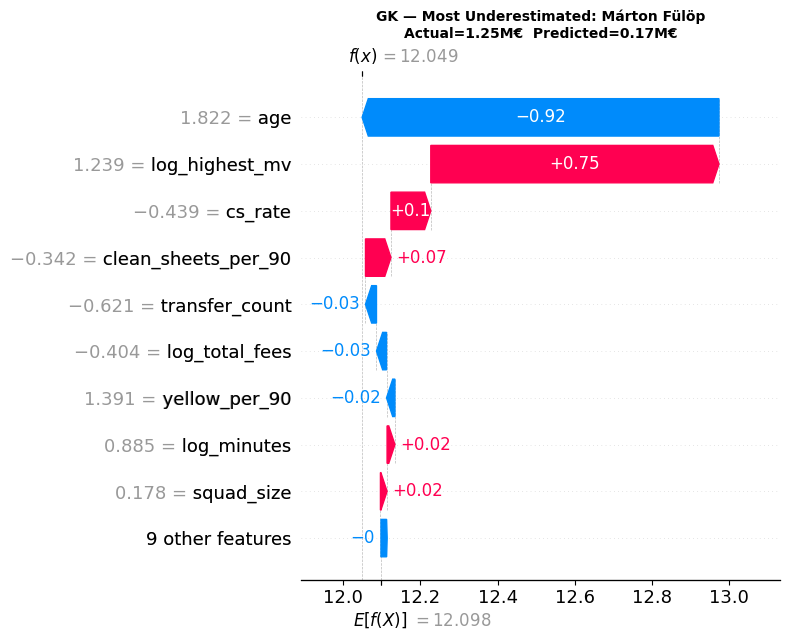

  GK: Márton Fülöp  actual=1.25M€  predicted=0.17M€


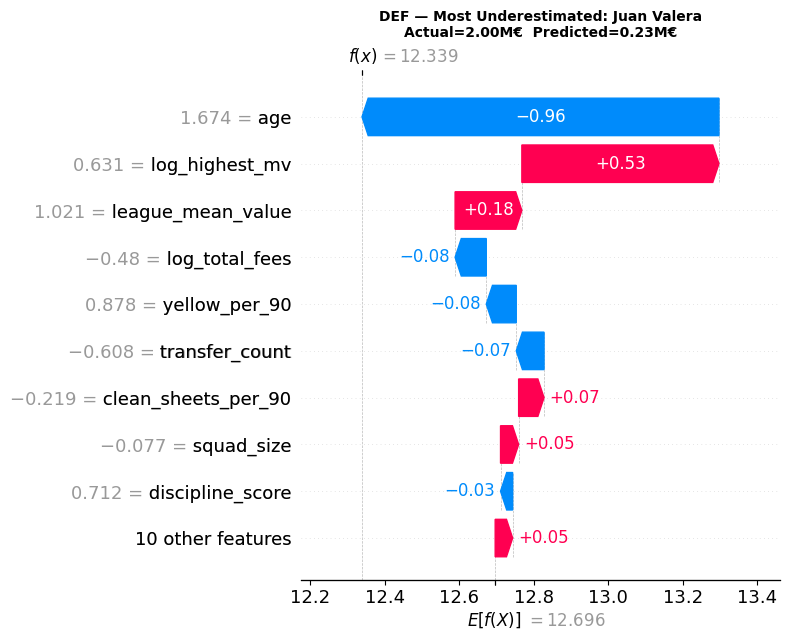

  DEF: Juan Valera  actual=2.00M€  predicted=0.23M€


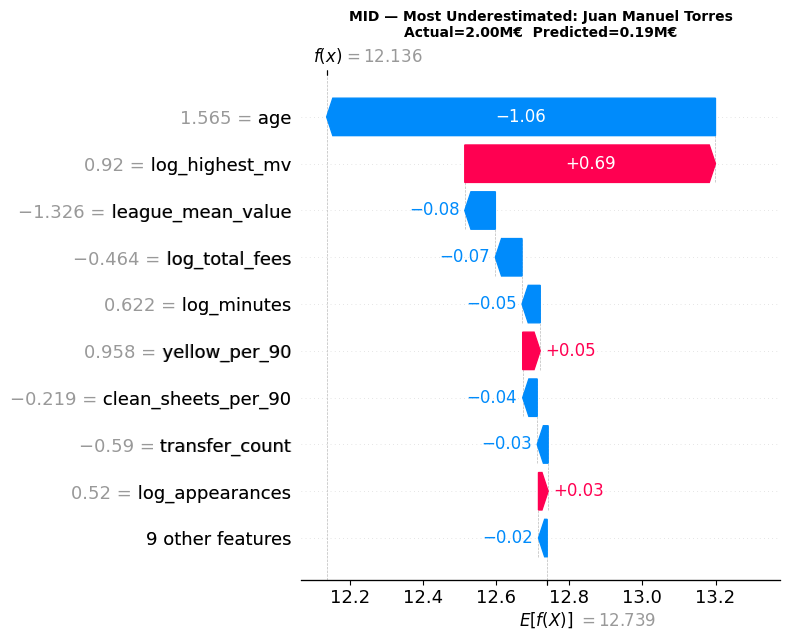

  MID: Juan Manuel Torres  actual=2.00M€  predicted=0.19M€


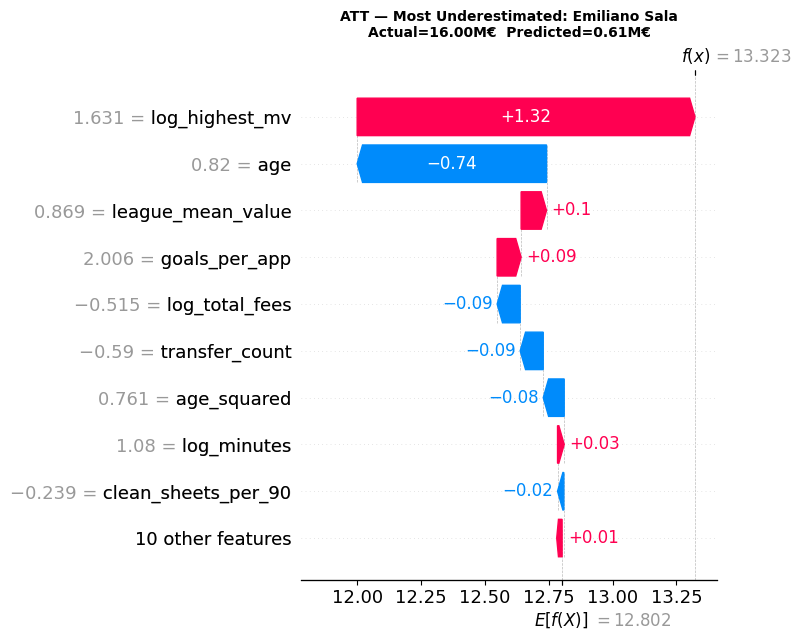

  ATT: Emiliano Sala  actual=16.00M€  predicted=0.61M€


In [12]:
if SHAP_AVAILABLE and shap_values_dict:
    for pos in POSITIONS:
        X_train, X_test, y_train, y_test = splits[pos]
        sv    = np.array(shap_values_dict[pos])
        feats = FINAL_FEATURES[pos]

        y_pred    = models[pos].predict(X_test)
        residuals = y_test.values - y_pred
        n_shap    = sv.shape[0]
        best_idx  = np.argmax(residuals[:n_shap])

        shap_exp = shap.Explanation(
            values        = sv[best_idx],
            base_values   = shap_expected_dict[pos],
            data          = X_test.iloc[best_idx].values,
            feature_names = feats
        )

        # Name lookup via row index into featured (integer-indexed)
        row_idx = y_test.index[best_idx]
        feat    = featured[pos]
        name    = feat.loc[row_idx, 'name'] if row_idx in feat.index else f'row_{row_idx}'
        actual  = np.expm1(y_test.iloc[best_idx]) / 1e6
        pred    = np.expm1(y_pred[best_idx]) / 1e6

        plt.figure(figsize=(9, 5))
        shap.plots.waterfall(shap_exp, show=False)
        plt.title(f'{pos} — Most Underestimated: {name}\n'
                  f'Actual={actual:.2f}M€  Predicted={pred:.2f}M€',
                  fontsize=10, fontweight='bold')
        plt.tight_layout()
        plt.savefig(FIGURES_PATH + f'08_shap_waterfall_{pos.lower()}.png')
        plt.show()
        print(f'  {pos}: {name}  actual={actual:.2f}M€  predicted={pred:.2f}M€')
else:
    print('Skipped — SHAP not available.')

## 9. Model Calibration — Predicted vs Actual by Decile

Are our predictions well-calibrated across the value spectrum?
A perfect model would have the mean predicted = mean actual for every decile.

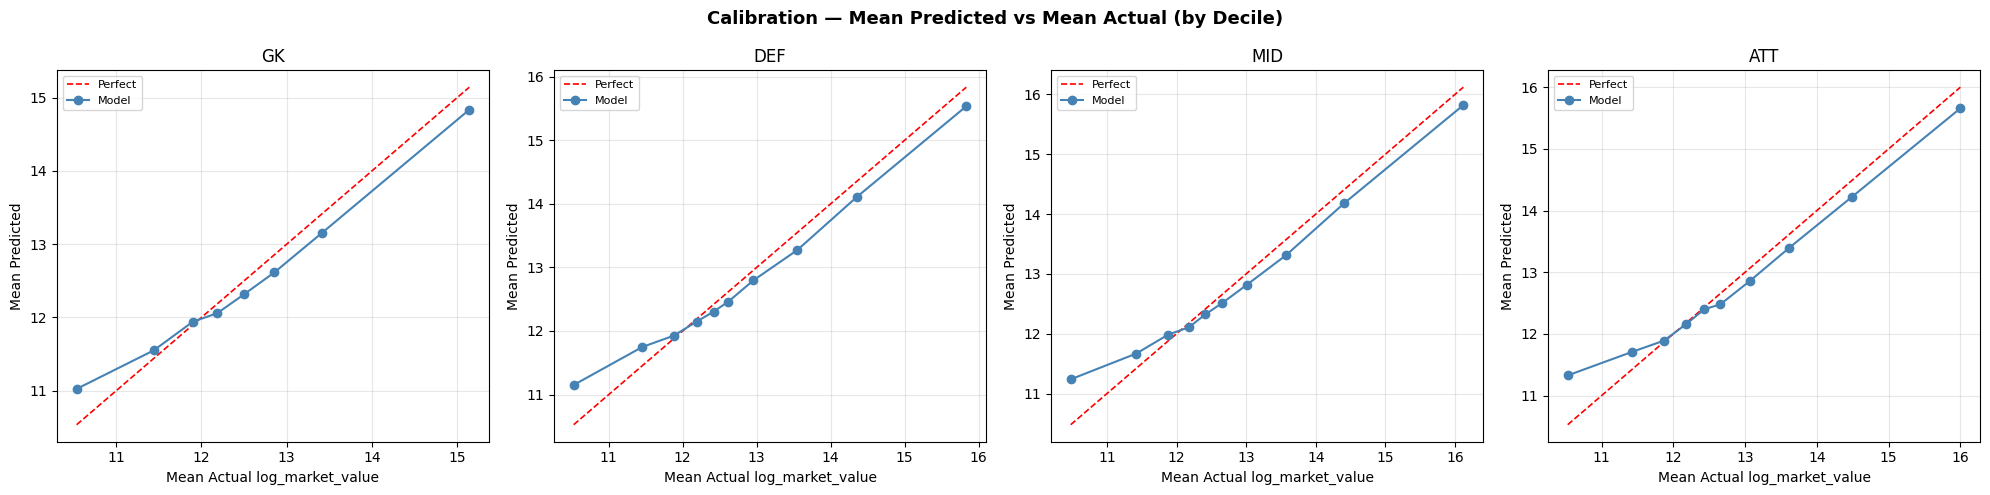

Saved.


In [13]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for ax, pos in zip(axes, POSITIONS):
    X_train, X_test, y_train, y_test = splits[pos]
    y_pred = models[pos].predict(X_test)

    df_cal = pd.DataFrame({'actual': y_test.values, 'pred': y_pred})
    df_cal['decile'] = pd.qcut(df_cal['actual'], q=10, labels=False, duplicates='drop')

    cal = df_cal.groupby('decile').agg(actual_mean=('actual','mean'), pred_mean=('pred','mean'))

    ax.plot(cal['actual_mean'], cal['actual_mean'], 'r--', linewidth=1.2, label='Perfect')
    ax.plot(cal['actual_mean'], cal['pred_mean'],   'o-',  color='steelblue', linewidth=1.5, label='Model')
    ax.set_xlabel('Mean Actual log_market_value')
    ax.set_ylabel('Mean Predicted')
    ax.set_title(f'{pos}')
    ax.legend(fontsize=8)
    ax.grid(alpha=0.3)

plt.suptitle('Calibration — Mean Predicted vs Mean Actual (by Decile)', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig(FIGURES_PATH + '08_calibration.png')
plt.show()
print('Saved.')

## 10. Validation

In [14]:
errors = []

for pos in POSITIONS:
    X_train, X_test, y_train, y_test = splits[pos]
    model  = models[pos]
    y_pred = model.predict(X_test)

    # 1. Predictions are finite
    if not np.isfinite(y_pred).all():
        errors.append(f'{pos}: non-finite predictions')
    else:
        print(f'✓  {pos}: all predictions finite')

    # 2. Mean residual close to 0 (no systematic bias, tolerance ±0.1)
    mean_res = (y_test.values - y_pred).mean()
    if abs(mean_res) > 0.1:
        errors.append(f'{pos}: mean residual={mean_res:.3f} — systematic bias')
    else:
        print(f'✓  {pos}: mean residual={mean_res:.4f} (no systematic bias)')

    # 3. SHAP values computed (if available)
    if SHAP_AVAILABLE:
        if pos not in shap_values_dict:
            errors.append(f'{pos}: SHAP values missing')
        else:
            print(f'✓  {pos}: SHAP values present')

    # 4. Test row indices all exist in featured data (same 0-based index)
    feat      = featured[pos]
    test_idxs = set(y_test.index)
    feat_idxs = set(feat.index)
    unmatched = test_idxs - feat_idxs
    if unmatched:
        errors.append(f'{pos}: {len(unmatched)} test row indices not in featured data')
    else:
        print(f'✓  {pos}: all test indices aligned with featured data')

    print()

print('=' * 50)
if errors:
    print(f'FAILED — {len(errors)} issue(s):')
    for e in errors: print(f'  ✗  {e}')
else:
    print('ALL CHECKS PASSED ✓')
    print('Ready for notebook 09 — undervalued players & dream team.')
print('=' * 50)

✓  GK: all predictions finite
✓  GK: mean residual=-0.0286 (no systematic bias)
✓  GK: SHAP values present
✓  GK: all test indices aligned with featured data

✓  DEF: all predictions finite
✓  DEF: mean residual=-0.0074 (no systematic bias)
✓  DEF: SHAP values present
✓  DEF: all test indices aligned with featured data

✓  MID: all predictions finite
✓  MID: mean residual=-0.0233 (no systematic bias)
✓  MID: SHAP values present
✓  MID: all test indices aligned with featured data

✓  ATT: all predictions finite
✓  ATT: mean residual=-0.0073 (no systematic bias)
✓  ATT: SHAP values present
✓  ATT: all test indices aligned with featured data

ALL CHECKS PASSED ✓
Ready for notebook 09 — undervalued players & dream team.


## 11. Save SHAP Values

In [15]:
if SHAP_AVAILABLE and shap_values_dict:
    for pos in POSITIONS:
        np.save(PROC_PATH + f'shap_values_{pos.lower()}.npy',
                np.array(shap_values_dict[pos]))
        np.save(PROC_PATH + f'shap_base_{pos.lower()}.npy',
                np.array([shap_expected_dict[pos]]))
    print('SHAP values saved:')
    for pos in POSITIONS:
        shape = np.array(shap_values_dict[pos]).shape
        print(f'  shap_values_{pos.lower()}.npy  {shape}')
else:
    print('SHAP not available — nothing to save.')

# Summary of all figures generated
print()
print('Figures generated:')
for f in sorted(os.listdir(FIGURES_PATH)):
    if f.startswith('08_'):
        print(f'  {f}')

SHAP values saved:
  shap_values_gk.npy  (663, 18)
  shap_values_def.npy  (1974, 19)
  shap_values_mid.npy  (1796, 18)
  shap_values_att.npy  (1711, 19)

Figures generated:
  08_calibration.png
  08_error_by_age.png
  08_error_by_value_range.png
  08_residual_distribution.png
  08_shap_bar.png
  08_shap_beeswarm_att.png
  08_shap_beeswarm_def.png
  08_shap_beeswarm_gk.png
  08_shap_beeswarm_mid.png
  08_shap_waterfall_att.png
  08_shap_waterfall_def.png
  08_shap_waterfall_gk.png
  08_shap_waterfall_mid.png
